## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [61]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from random import sample 
import tensorflow as tf
import sklearn.model_selection as skl
from sklearn.metrics import roc_curve, auc
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import RMSprop
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, Dropout, Flatten, Conv2D, BatchNormalization, AveragePooling2D

## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
108045,00029235_003.png,Effusion|Infiltration,3,29235,69,F,AP,3056,2544,0.139,0.139,NaN,/data/images_012/images/00029235_003.png
10377,00002689_000.png,Infiltration|Pleural_Thickening,0,2689,54,F,PA,2048,2500,0.168,0.168,NaN,/data/images_002/images/00002689_000.png
99483,00026330_002.png,Mass,2,26330,43,M,PA,2992,2991,0.143,0.143,NaN,/data/images_011/images/00026330_002.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
# Making a copy of the DF to not make any alterations in the original dataset 
df = all_xray_df.copy()

all_labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

for c_label in all_labels:
    class_label = c_label + "_class"
    if len(c_label)>1: # leave out empty labels
        df[class_label.lower()] = df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,emphysema_class,fibrosis_class,hernia_class,infiltration_class,mass_class,no finding_class,nodule_class,pleural_thickening_class,pneumonia_class,pneumothorax_class
99683,00026408_001.png,No Finding,1,26408,53,M,AP,3056,2544,0.139,...,0,0,0,0,0,1,0,0,0,0
73854,00018175_007.png,No Finding,7,18175,55,M,PA,2762,2991,0.143,...,0,0,0,0,0,1,0,0,0,0
78729,00019313_008.png,No Finding,8,19313,65,M,AP,2500,2048,0.168,...,0,0,0,0,0,1,0,0,0,0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# The column was created in the previous cell
df['pneumonia_class'] = df['pneumonia_class'].astype(int)

df['pneumonia_class']

0         0
1         0
2         0
3         0
4         0
         ..
112115    1
112116    0
112117    0
112118    0
112119    0
Name: pneumonia_class, Length: 112120, dtype: int64

## Create your training and testing data:

In [5]:
def create_splits(dataframe, balance_split, column):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    
    train_data, val_data = skl.train_test_split(dataframe, 
                                   test_size = balance_split, 
                                   stratify = df[column])
    
    
    return train_data, val_data

In [6]:
train_df, val_df = create_splits(df, 0.2, 'pneumonia_class')

In [7]:
train_df['pneumonia_class'].sum()/len(train_df)

0.012765340706386016

In [8]:
val_df['pneumonia_class'].sum()/len(val_df)

0.012754191937210132

In [9]:
p_inds = train_df[train_df.pneumonia_class==1].index.tolist()
np_inds = train_df[train_df.pneumonia_class==0].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_df = train_df.loc[p_inds + np_sample]

In [10]:
# Training balacing
train_df['pneumonia_class'].sum()/len(train_df)

0.5

In [11]:
p_inds = val_df[val_df.pneumonia_class==1].index.tolist()
np_inds = val_df[val_df.pneumonia_class==0].index.tolist()

np_sample = sample(np_inds,4*len(p_inds))
val_df = val_df.loc[p_inds + np_sample]

In [12]:
# Validation balancing
val_df['pneumonia_class'].sum()/len(val_df)

0.2

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [13]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)
    
    return idg


def make_train_gen(train_df, x_axis, y_axis, target, batch):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    my_train_idg = my_image_augmentation()
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                              directory=None, 
                                              x_col = x_axis,
                                              y_col = y_axis,
                                              class_mode = 'raw',
                                              target_size = target, 
                                              batch_size = batch
                                            )
    return train_gen


def make_val_gen(val_data, x_axis, y_axis, target, batch):
    my_val_idg = ImageDataGenerator(rescale=1. / 255.0)
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
                                              directory=None, 
                                              x_col = x_axis,
                                              y_col = y_axis,
                                              class_mode = 'raw',
                                              target_size = target, 
                                              batch_size = batch
                                            ) 
    
    return val_gen


In [14]:
# Declaring default variables
x_axis = 'path'
y_axis = 'pneumonia_class'
target = (224, 224)
batch = 64

# Generating images for training and validation datasets
train_gen = make_train_gen(train_df, x_axis, y_axis, target, batch)
val_gen = make_val_gen(val_df, x_axis, y_axis, target, batch)

Found 2290 validated image filenames.
Found 1430 validated image filenames.


In [15]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

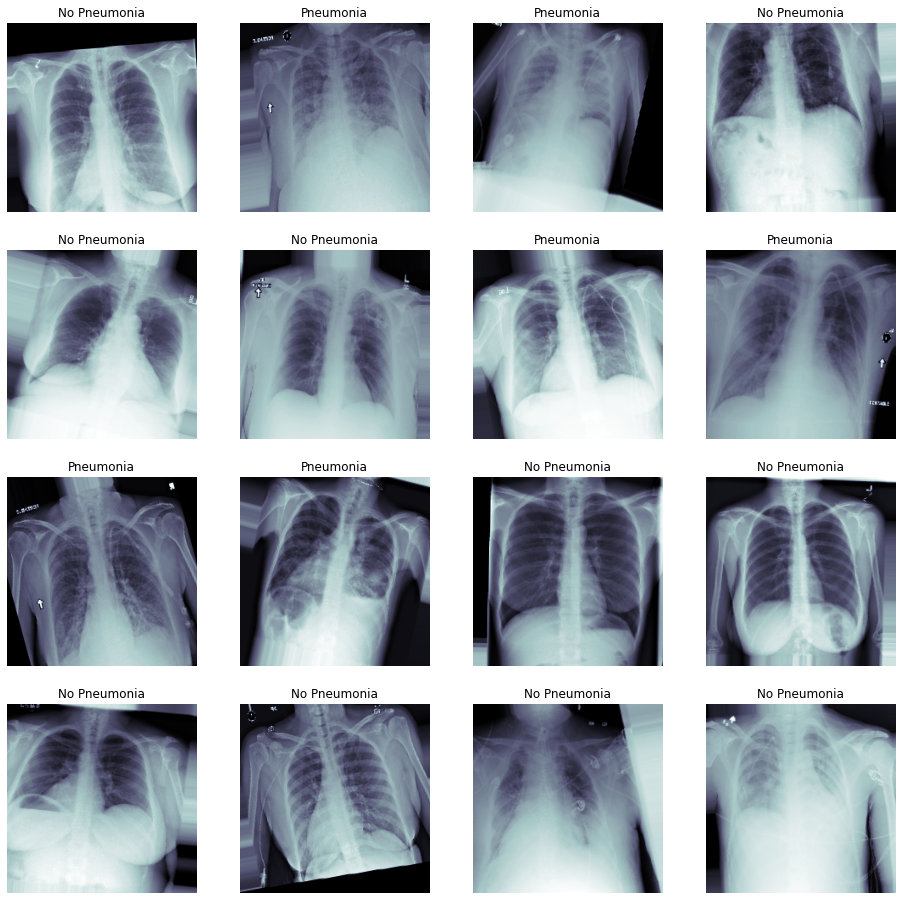

In [16]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [58]:
def load_pretrained_model():
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    return vgg_model


In [62]:
def build_my_model():
    
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    vgg_model = load_pretrained_model()
    
    my_model = Sequential([vgg_model,
                        BatchNormalization(),
                        Conv2D(1024, 1, activation='relu'),
                        Dropout(0.5),
                        BatchNormalization(),
                        Conv2D(256, 1, activation='relu'),
                        Dropout(0.5),                        
                        AveragePooling2D((7,7)),
                        BatchNormalization(),
                        Conv2D(1, 1, activation='sigmoid'),
                        Reshape((-1,))
                       ])
    
    return my_model

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [63]:
model = build_my_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 512)         2048      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 1024)        525312    
_________________________________________________________________
dropout_14 (Dropout)         (None, 7, 7, 1024)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 1024)        4096      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 256)         262400    
_________________________________________________________________
dropout_15 (Dropout)         (None, 7, 7, 256)        

In [64]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= "val_loss", 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'auto', 
                             save_weights_only = False)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'auto', 
                      patience=5)

def scheduler(epoch, lr):
    print("learning rate %.2E"%lr)
    if epoch < 2:
        return lr
    else:
        return lr * np.exp(-0.1)
    
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

callbacks_list = [checkpoint, early]

### Start training! 

In [65]:
## train your model

# Todo
## Set our optimizer, loss function, and learning rate
optimizer = Adam(lr=1e-3)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = model.fit_generator(train_gen, 
                          validation_data = val_gen, 
                          epochs = 5, 
                          callbacks = callbacks_list)

Epoch 1/5
36/36 [==============================] - 76s 2s/step - loss: 0.8126 - binary_accuracy: 0.5742 - val_loss: 0.5619 - val_binary_accuracy: 0.7713

Epoch 00001: val_loss improved from inf to 0.56189, saving model to xray_class_my_model.best.hdf5
Epoch 2/5
36/36 [==============================] - 65s 2s/step - loss: 0.7003 - binary_accuracy: 0.6052 - val_loss: 0.5113 - val_binary_accuracy: 0.7958

Epoch 00002: val_loss improved from 0.56189 to 0.51130, saving model to xray_class_my_model.best.hdf5
Epoch 3/5
36/36 [==============================] - 65s 2s/step - loss: 0.6684 - binary_accuracy: 0.6157 - val_loss: 0.5946 - val_binary_accuracy: 0.6336

Epoch 00003: val_loss did not improve from 0.51130
Epoch 4/5
36/36 [==============================] - 64s 2s/step - loss: 0.6633 - binary_accuracy: 0.6279 - val_loss: 0.6715 - val_binary_accuracy: 0.6510

Epoch 00004: val_loss did not improve from 0.51130
Epoch 5/5
36/36 [==============================] - 63s 2s/step - loss: 0.6446 - bi

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [66]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
val_Y = val_df['pneumonia_class']
model.load_weights(weight_path)
pred_Y = model.predict(val_gen, verbose = True)

23/23 [==============================] - 22s 974ms/step


In [67]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix
def plot_auc(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
    return

def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    
#Also consider plotting the history of your model training:

def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.show()
    return

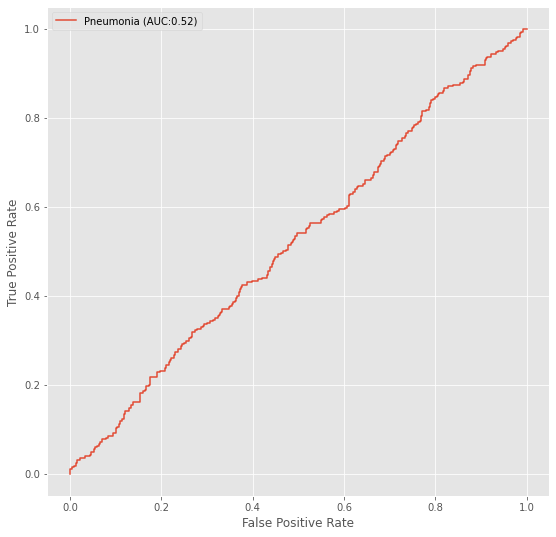

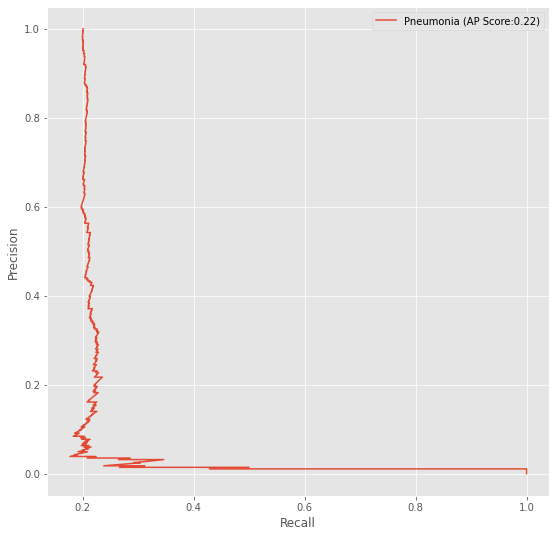

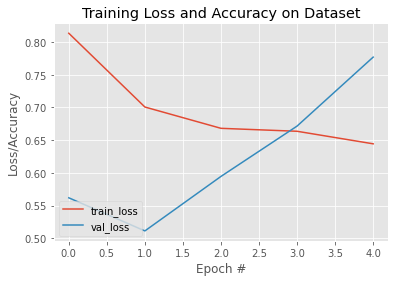

In [68]:
## plot figures
plot_auc(val_Y, pred_Y)
plot_pr(val_Y, pred_Y)
plot_history(history)
# Todo

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [70]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

precision, recall, thresholds = precision_recall_curve(val_Y, pred_Y)

# Look at the threshold where precision is 0.8
precision_value = 0.8
idx = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

YOUR_THRESHOLD = thresholds[idx]

Precision is: 0.75
Recall is: 0.01048951048951049
Threshold is: 0.5477449
F1 Score is: 0.020689655172413793


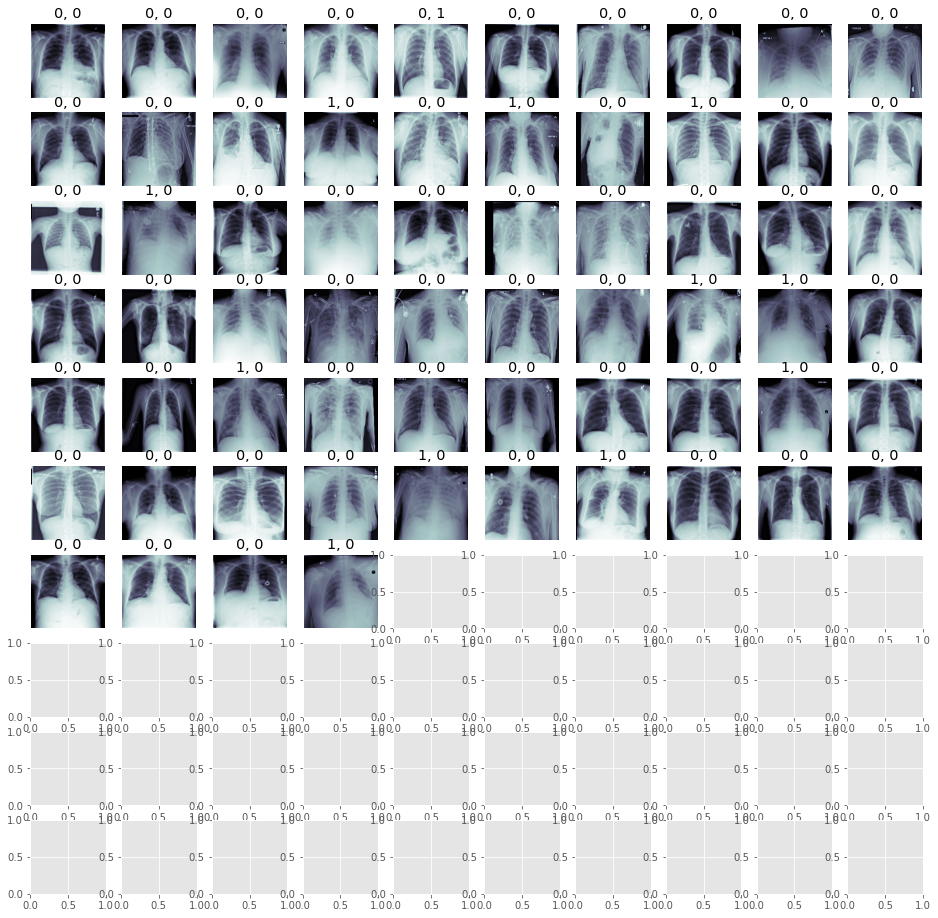

In [73]:
## Let's look at some examples of predicted v. true with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:64], valY[0:64], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [75]:
## Just save model architecture to a .json:

model_json = model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)